# Marketing Prediction of Bank Offers

The goal of this project is to predict the accepting of an offer from a bank.
The data is related with direct marketing campaigns (phone calls) of a [Portuguese banking institution](https://archive.ics.uci.edu/dataset/222/bank+marketing).

In [201]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from category_encoders import TargetEncoder,JamesSteinEncoder

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [202]:
# even though its a CSV file but the columns are separated with ';' so used that as separator otherwise it wont load any data since read_csv defaults to ','
bank_df = pd.read_csv("bank-additional/bank-additional-full.csv",sep=";")
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [23]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## Data Analysis

Lets look at the data with some plots using matplotlib and seaborn to see what the story  the data tells.

In [12]:
# check for nulls
bank_df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [92]:
# lets check for duplicates
print('Duplicated Row: ',bank_df.duplicated().sum())

Duplicated Row:  12


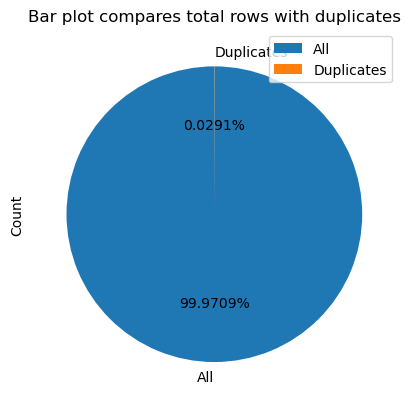

In [40]:
#lets plot the duplicates
labels = ['All', 'Duplicates']
counts = [len(bank_df),len(bank_df[bank_df.duplicated()])]
plt.pie(counts,labels=labels,autopct='%1.4f%%', startangle=90)
plt.title("Bar plot compares total rows with duplicates")
plt.ylabel("Count")
plt.legend()
plt.show()

These seems 12 rows of duplicates in the dataset, lets cleanup these since they will impact the performacne of the model.

In [203]:
# remove the dupliates
bank_df_processed = bank_df.drop_duplicates()

This dataset doesnt  have any  null values.

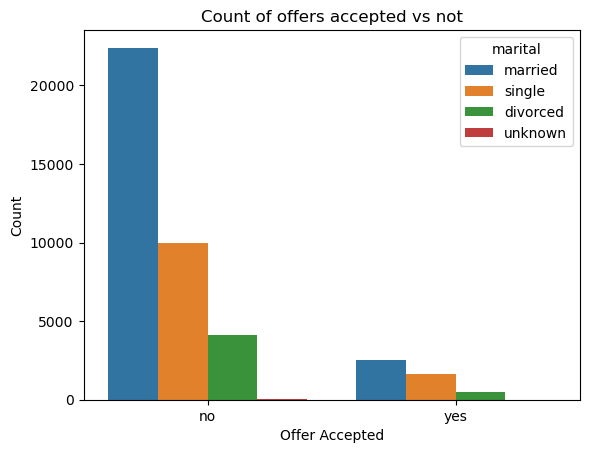

In [45]:
# Check how many people accepted the offer vs not using bar plot with respective to marital status
plt.title("Count of offers accepted vs not")
sns.countplot(bank_df_processed,x='y',hue='marital')
plt.xlabel('Offer Accepted')
plt.ylabel('Count')
plt.show()

The above plot tells that many people didnt accepted offers. The offer acceptance % seems very less compared to total population.

### Accepted Data Analyis

In [59]:
# get the data only for offer accepted
offers_accepted = bank_df_processed.query("y == 'yes'")
offers_accepted.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
75,41,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
83,49,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
88,49,technician,married,basic.9y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
129,41,technician,married,professional.course,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
139,45,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes


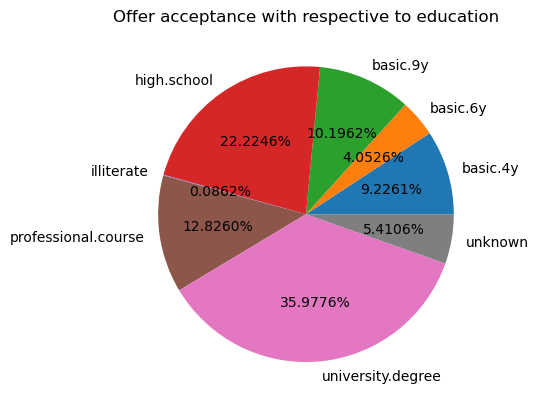

In [57]:
offers_accepted_by_education = offers_accepted.groupby('education').size()
plt.title('Offer acceptance with respective to education')
plt.pie(offers_accepted_by_education,labels=offers_accepted_by_education.index,autopct='%1.4f%%')
plt.show()

People with  university degree accepted the offers alot than other people

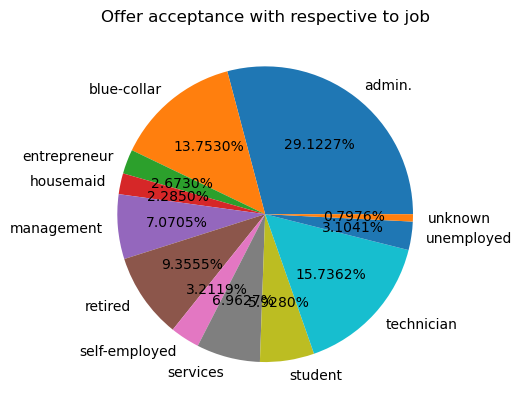

In [62]:
offers_accepted_by_job = offers_accepted.groupby('job').size()
plt.title('Offer acceptance with respective to job')
plt.pie(offers_accepted_by_job,labels=offers_accepted_by_job.index,autopct='%1.4f%%')
plt.show()

It seems pleople are doing admin job are accepted many offers than other people.

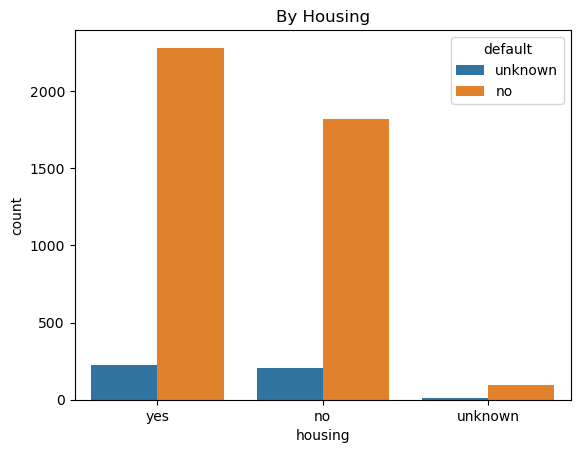

In [67]:
plt.title('By Housing')
sns.countplot(offers_accepted,x = 'housing', hue='default')
plt.show()

<Axes: xlabel='contact', ylabel='age'>

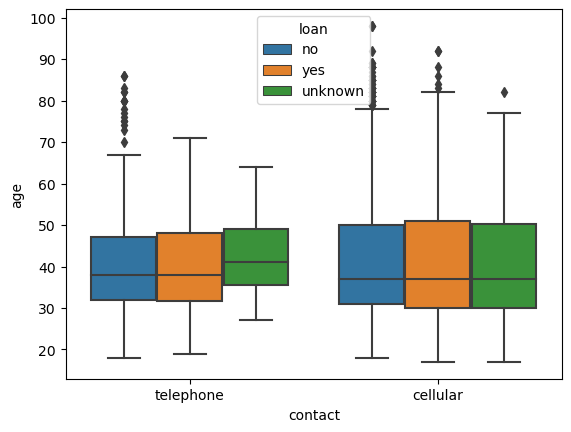

In [83]:
sns.boxplot(data=offers_accepted, x="contact",y="age", hue="loan")

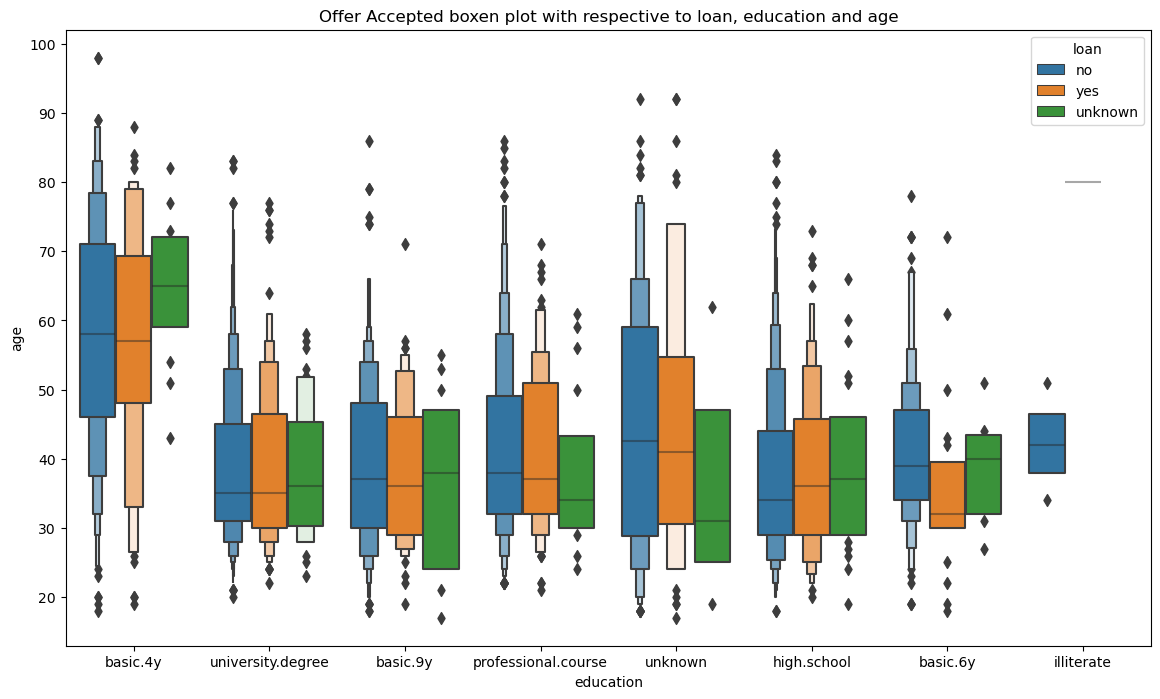

In [89]:
plt.figure(figsize=(14,8))
plt.title("Offer Accepted boxen plot with respective to loan, education and age")
sns.boxenplot(data=offers_accepted, x="education",y="age", hue="loan")
plt.show()

### Run the similar analysis on Full Data Set

## Data Preparation
Lets cleanup the data by converting the categorical features into numerical values.

In [204]:
bank_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

There seems quite a few categorical features, and in these *education*, *month*, *day_of_week* are ordinal categories for which probably  we need to use **OrinalEncoder** and for other we can use **LabelEncoder**  or **TargetEncoder**

In [205]:
# find out the categorical values of the education  feature to define the order
bank_df_processed['education'].astype('category').values

['basic.4y', 'high.school', 'high.school', 'basic.6y', 'high.school', ..., 'professional.course', 'professional.course', 'university.degree', 'professional.course', 'professional.course']
Length: 41176
Categories (8, object): ['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown']

In [207]:
#find out unique values of various features to do encoding with order
print(np.unique(bank_df_processed['month'].astype('category').values))
print(np.unique(bank_df_processed['day_of_week'].astype('category').values))

['apr' 'aug' 'dec' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
['fri' 'mon' 'thu' 'tue' 'wed']


In [209]:
month_values_order=[['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']]
day_of_week_values_order = [['mon','tue','wed','thu','fri','sat','sun']]
education_values_order = [['unknown','illiterate','basic.4y', 'basic.6y', 'basic.9y', 'high.school','university.degree','professional.course']]

In [212]:
X = bank_df_processed.drop('y',axis=1)
y = bank_df_processed['y']

In [217]:
# build pipeline for encoding using column transformer
ordinal_encoder_transformer = make_column_transformer(
    (OrdinalEncoder(categories=education_values_order), ['education']),
    (OrdinalEncoder(categories=month_values_order), ['month']),
    (OrdinalEncoder(categories=day_of_week_values_order), ['day_of_week']),
    remainder='passthrough'  # otherwise it will encode only the above 3 features and drop others
)

#X_encoded = ordinal_encoder_transformer.fit_transform(X)
#X = pd.DataFrame(X_encoded,columns=X.columns)
#X.sample(50, random_state=42)

In [214]:
columns = ['job','marital','default','housing','loan','contact','poutcome','y']
for col in columns:
    bank_df_processed[col] = LabelEncoder().fit_transform(bank_df_processed[col])


bank_df_processed.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,basic.4y,0,0,0,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,high.school,1,0,0,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,high.school,0,2,0,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,basic.6y,0,0,0,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,high.school,0,0,2,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [218]:
bank_df_processed_encoded = ordinal_encoder_transformer.fit_transform(bank_df_processed)

In [219]:
bank_df_encoded = pd.DataFrame(bank_df_processed_encoded,columns=bank_df_processed.columns)
bank_df_encoded.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,2.0,4.0,0.0,56.0,3.0,1.0,0.0,0.0,0.0,1.0,...,1.0,999.0,0.0,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0
1,5.0,4.0,0.0,57.0,7.0,1.0,1.0,0.0,0.0,1.0,...,1.0,999.0,0.0,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0
2,5.0,4.0,0.0,37.0,7.0,1.0,0.0,2.0,0.0,1.0,...,1.0,999.0,0.0,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0
3,3.0,4.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,999.0,0.0,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0
4,5.0,4.0,0.0,56.0,7.0,1.0,0.0,0.0,2.0,1.0,...,1.0,999.0,0.0,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0
